<a href="https://colab.research.google.com/github/MariaNguen/Kaggle_NLP_Disaster-Tweets/blob/main/BERT_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание "Почувствуй мощь трансформеров в бою"

В качестве данных выберете возьмите датасет RuCola для русского языка https://github.com/RussianNLP/RuCoLA (в качестве train возьмите in_domain_train.csv, а в качестве теста in_domain_dev.csv)

Разбейте in_domain_train на train и val

Зафайнтьюньте и протестируйте RuBert или RuRoBerta на данной задаче (можно взять любую предобученную модель руберт с сайта huggingface. Например, ruBert-base/large https://huggingface.co/sberbank-ai/ruBert-base / https://huggingface.co/sberbank-ai/ruBert-large или rubert-base-cased https://huggingface.co/DeepPavlov/rubert-base-cased, ruRoberta-large https://huggingface.co/sberbank-ai/ruRoberta-large, xlm-roberta-base https://huggingface.co/xlm-roberta-base)

Возьмите RuGPT3 base или large и решите данное задание с помощью методов few-/zero-shot

а) переберите несколько вариантов затравок

б) протестируйте различное число few-shot примеров (0, 1, 2, 4)

Обучите и протестируйте модель RuT5 на данной задаче (пример finetun’а можете найти здесь https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py)
Сравните полученные результаты

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!pip install transformers

##Загрузка данных

In [2]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/in_domain_train.csv", sep=',', on_bad_lines='skip')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 7,869



,id,sentence,acceptable,error_type,detailed_source
5024,5024,Мне слышится что-то родное.,1,0,Paducheva2004
7570,7570,"Увидев Андрея рядом с командиром, всё стало ле...",0,Syntax,USE8
6485,6485,"И вдруг однажды замечаю, что в одной из бутыло...",1,0,Rusgram
4066,4066,Соломон Волков хочет насильно выпустить книгу ...,1,0,Testelets
6621,6621,После этого я получила отвращение к азартным и...,1,0,Seliverstova
5779,5779,"Осип Брик в ряде статей обнаружил, что он нико...",1,0,Paducheva2004
133,133,"Иван знает, что приехала Маша.",1,0,Paducheva2013
408,408,Фишер уронил себя отказом от игры.,1,0,Paducheva2013
2022,2022,Мальчик высунулся из окна.,1,0,Paducheva2010
2918,2918,"С такими, как он, часто что-нибудь случается.",1,0,Rusgram


In [3]:
# Load the dataset into a pandas dataframe.
test = pd.read_csv("/content/in_domain_dev.csv", sep=',', on_bad_lines='skip')

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Display 10 random rows from the data.
test.sample(10)

Number of test sentences: 983



,id,sentence,acceptable,error_type,detailed_source
562,562,Человек смотрит в окно.,1,0,Paducheva2004
147,147,"Между тем он по-прежнему отрицает свою вину, г...",1,0,Paducheva2004
99,99,Этот будь был очень тяжелым.,0,Syntax,Testelets
471,471,Поход на пляж не должен окончиться неприятност...,1,0,Paducheva2013
102,102,Меня рассердила его невнимательность.,1,0,Paducheva2004
458,458,Близ стола стояло большое кресло.,0,Semantics,Seliverstova
838,838,Она не будет менять свой план из-за тебя.,1,0,Paducheva2013
543,543,Букинист с особой целью продал книгу студенту.,1,0,Testelets
883,883,"Вообще-то он в институте, но сейчас он вышел.",1,0,Seliverstova
17,17,Кожа у виска была желтой.,1,0,Seliverstova


##RuBERT

###Токенизация

In [5]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-base')
tokenizer

Loading BERT tokenizer...


BertTokenizer(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [6]:
# Print the original sentence.
print(' Original: ', df['sentence'][0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df['sentence'][0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['sentence'][0])))

 Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Tokenized:  ['вдруг', 'решетка', 'беззвучно', 'поехала', 'в', 'сторону', ',', 'и', 'на', 'балконе', 'возникла', 'таинственная', 'фигура', ',', 'прячу', '##щаяся', 'от', 'лунного', 'света', ',', 'и', 'погрозил', '##а', 'ива', '##ну', 'пальцем', '.']
Token IDs:  [3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 104691, 717, 11420, 126]


In [7]:
max_len = 0

# For every sentence...
for sent in df['sentence']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [8]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df['sentence']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['acceptable'])

# Print sentence 0, now as a list of IDs.
print('Original: ', df['sentence'][0])
print('Token IDs:', input_ids[0])

Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,   3014,  83321,  41548,  32350,    113,   2931,    121,    107,
           660,  50354,  13779,  99183,  15226,    121,  94376,  19913,    700,
         55918,   6412,    121,    107,  95640,    377, 104691,    717,  11420,
           126,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0])


###Training and validation split

In [9]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,082 training samples
  787 validation samples


Создадим также итератор.

In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Обучение модели

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "ai-forever/ruBert-base", # Use ruBert-base
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [13]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 3, because the model overfits on 4 epochs
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Вспомогательная функция для вычисления точности.

In [14]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Вспомогательная функция для отслеживания затраченного времени.

In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Запускаем обучение.

In [16]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:12.
  Batch    80  of    222.    Elapsed: 0:00:25.
  Batch   120  of    222.    Elapsed: 0:00:36.
  Batch   160  of    222.    Elapsed: 0:00:48.
  Batch   200  of    222.    Elapsed: 0:00:59.

  Average training loss: 0.55
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.52
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:12.
  Batch    80  of    222.    Elapsed: 0:00:23.
  Batch   120  of    222.    Elapsed: 0:00:35.
  Batch   160  of    222.    Elapsed: 0:00:47.
  Batch   200  of    222.    Elapsed: 0:00:59.

  Average training loss: 0.45
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.50
  Validation took: 0:00:02

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:12.
  Batch    80  of    222.    Elapsed: 0:00:23.
 

Посмотрим на саммари обучающего процесса.

In [17]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.549253,0.515040,0.765329,0:01:05,0:00:02
2,0.452035,0.499187,0.784079,0:01:05,0:00:02
3,0.366303,0.488552,0.804474,0:01:04,0:00:02


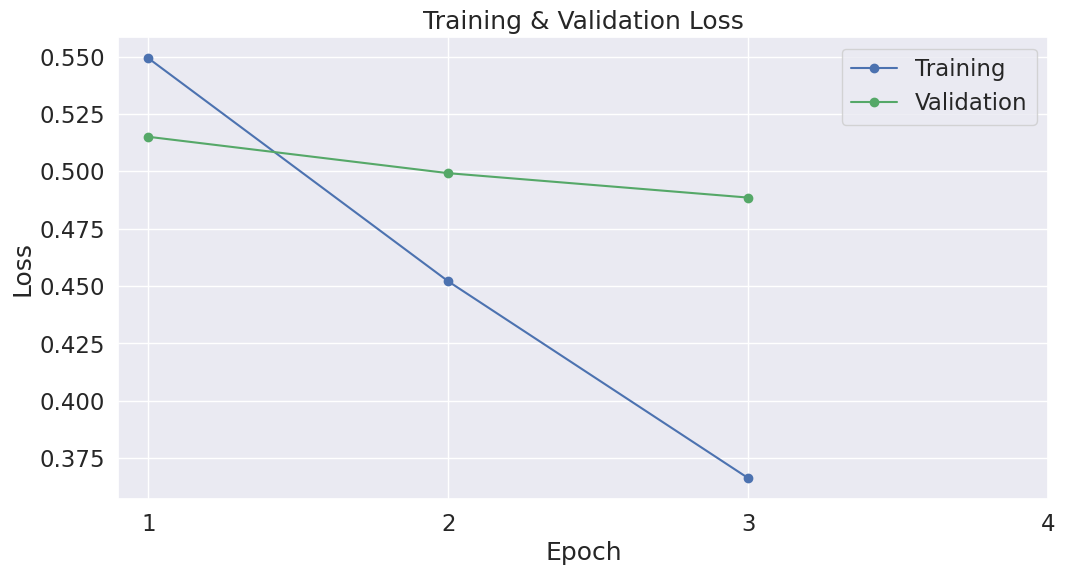

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

###Тестирование модели

Предобработаем тестовый датасет так, как мы предобрабатывали обучающий и валидационный.

In [19]:


# Create sentence and label lists
sentences = test.sentence.values
labels = test.acceptable.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [20]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 983 test sentences...
    DONE.


In [21]:
print('Positive samples: %d of %d (%.2f%%)' % (test.acceptable.sum(), len(test.acceptable), (test.acceptable.sum() / len(test.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


In [22]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [23]:
from sklearn.metrics import matthews_corrcoef
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.332


##RuGPT-3

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3large_based_on_gpt2")
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3large_based_on_gpt2")

model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1536, out_features=50257, bias=False)
)

### Loss function

In [25]:
import math
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase)
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, dtype=torch.long, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    loss[0].item()


    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model, tokenizer=tokenizer)
    return loss

def clean(text):
    text = re.sub(r'\((\d+)\)', '', text)
    return text

### Zero-shot

Напишем функцию, котора будет предсказывать корректность предложения. На вход будет получать затравки для корректного и некорректного предложений и предложение, корректность которого надо оценить.

In [26]:
def liguistic_acceptability(prompts, text):
  incorrect_prompt = prompts[0].format(sentence=text)
  correct_prompt = prompts[1].format(sentence=text)
  incorrect_loss = get_loss_num(incorrect_prompt)
  correct_loss = get_loss_num(correct_prompt)
  return np.argmax([incorrect_loss, correct_loss])

In [27]:
df.head(15)

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010
5,5,Он всегда сидит в библиотеке.,1,0,Seliverstova
6,6,"Представляю, как смешно это выглядело снизу.",1,0,Paducheva2004
7,7,"Мне предоставилась возможность все видеть, сам...",0,Syntax,Testelets
8,8,Наш новый сотрудник оказался коренастым мужчин...,1,0,USE5
9,9,Регистрация была проведена сразу по прибытию у...,0,Syntax,USE8


In [28]:
prompts_v1 = [
    'Предложение далее корректное? {sentence} Ответ: нет.',
    'Предложение далее корректное? {sentence} Ответ: да.'
]

In [29]:
for i, s in enumerate(df['sentence'].head(15)):
  print(s)
  print('Acceptability:', df['acceptable'][i])
  prediction = liguistic_acceptability(prompts_v1, s)
  print('Predicted acceptability:', prediction)
  print()


Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Acceptability: 1
Predicted acceptability: 1

Этим летом не никуда ездили.
Acceptability: 0
Predicted acceptability: 1

Только Иван выразил какую бы то ни было готовность помочь.
Acceptability: 1
Predicted acceptability: 1

Теперь ты видишь собственными глазами, как тут хорошо.
Acceptability: 1
Predicted acceptability: 0

На поверку вся теория оказалась полной чепухой.
Acceptability: 1
Predicted acceptability: 1

Он всегда сидит в библиотеке.
Acceptability: 1
Predicted acceptability: 1

Представляю, как смешно это выглядело снизу.
Acceptability: 1
Predicted acceptability: 1

Мне предоставилась возможность все видеть, сам оставаясь незамеченным.
Acceptability: 0
Predicted acceptability: 0

Наш новый сотрудник оказался коренастым мужчиной лет сорока.
Acceptability: 1
Predicted acceptability: 0

Регистрация была проведена сразу по прибытию участников

In [30]:
def evaluate_predictions(data, prompts):
  sentences = data['sentence']
  true_labels = np.array(data['acceptable'])
  predicted_labels = []
  for s in sentences:
    prediction = liguistic_acceptability(prompts, s)
    predicted_labels.append(prediction)
  predicted_labels = np.array(predicted_labels)
  mcc = matthews_corrcoef(true_labels, predicted_labels)
  print('Total MCC: %.3f' % mcc)

In [31]:
evaluate_predictions(test, prompts_v1)

Total MCC: 0.080


Получаем коэффициент корреляции, близкий к нулю, т.е. это почти случайное угадывание.

Полпробуем другую затравку.

In [32]:
prompts_v2 = [
    'Предложение далее является грамматически корректным? {sentence} Ответ: нет.',
    'Предложение далее является грамматически корректным? {sentence} Ответ: да.'
]

In [33]:
for i, s in enumerate(df['sentence'].head(15)):
  print(s)
  print('Acceptability:', df['acceptable'][i])
  prediction = liguistic_acceptability(prompts_v2, s)
  print('Predicted acceptability:', prediction)
  print()


Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Acceptability: 1
Predicted acceptability: 1

Этим летом не никуда ездили.
Acceptability: 0
Predicted acceptability: 1

Только Иван выразил какую бы то ни было готовность помочь.
Acceptability: 1
Predicted acceptability: 0

Теперь ты видишь собственными глазами, как тут хорошо.
Acceptability: 1
Predicted acceptability: 0

На поверку вся теория оказалась полной чепухой.
Acceptability: 1
Predicted acceptability: 1

Он всегда сидит в библиотеке.
Acceptability: 1
Predicted acceptability: 1

Представляю, как смешно это выглядело снизу.
Acceptability: 1
Predicted acceptability: 1

Мне предоставилась возможность все видеть, сам оставаясь незамеченным.
Acceptability: 0
Predicted acceptability: 1

Наш новый сотрудник оказался коренастым мужчиной лет сорока.
Acceptability: 1
Predicted acceptability: 0

Регистрация была проведена сразу по прибытию участников

In [34]:
evaluate_predictions(test, prompts_v2)

Total MCC: 0.090


In [35]:
prompts_v3 = [
    'Грамматически корректное предложение: {sentence}',
    'Грамматически некорректное предложение: {sentence}'
]

In [36]:
for i, s in enumerate(df['sentence'].head(15)):
  print(s)
  print('Acceptability:', df['acceptable'][i])
  prediction = liguistic_acceptability(prompts_v3, s)
  print('Predicted acceptability:', prediction)
  print()


Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Acceptability: 1
Predicted acceptability: 0

Этим летом не никуда ездили.
Acceptability: 0
Predicted acceptability: 0

Только Иван выразил какую бы то ни было готовность помочь.
Acceptability: 1
Predicted acceptability: 0

Теперь ты видишь собственными глазами, как тут хорошо.
Acceptability: 1
Predicted acceptability: 1

На поверку вся теория оказалась полной чепухой.
Acceptability: 1
Predicted acceptability: 0

Он всегда сидит в библиотеке.
Acceptability: 1
Predicted acceptability: 1

Представляю, как смешно это выглядело снизу.
Acceptability: 1
Predicted acceptability: 0

Мне предоставилась возможность все видеть, сам оставаясь незамеченным.
Acceptability: 0
Predicted acceptability: 1

Наш новый сотрудник оказался коренастым мужчиной лет сорока.
Acceptability: 1
Predicted acceptability: 1

Регистрация была проведена сразу по прибытию участников

In [37]:
evaluate_predictions(test, prompts_v3)

Total MCC: 0.027


In [38]:
prompts_v4 = [
    'Грамматически верное предложение: {sentence}',
    'Грамматически неверное предложение: {sentence}'
]

In [39]:
evaluate_predictions(test, prompts_v4)

Total MCC: 0.000


In [40]:
prompts_v5 = [
    'Грамматически правильное предложение: {sentence}',
    'Грамматически неправильное предложение: {sentence}'
]

In [41]:
evaluate_predictions(test, prompts_v5)

Total MCC: -0.021


### Two-shot
Попробуем затравки с примерами.

In [42]:
example_2shot = [
    'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
    'Наш новый сотрудник оказался коренастым мужчиной лет сорока.'
]

In [43]:
def two_shot_prompts(prompts, examples):
  incorrect = prompts[0].format(sentence=examples[0])+'\n' + prompts[1].format(sentence=examples[1])+'\n'+prompts[0]
  correct = prompts[0].format(sentence=examples[0])+'\n' + prompts[1].format(sentence=examples[1])+'\n'+prompts[1]
  return [incorrect, correct]

In [44]:
prompts_v1_2shot = two_shot_prompts(prompts_v1, example_2shot)

In [45]:
evaluate_predictions(test, prompts_v1_2shot)

Total MCC: 0.059


In [46]:
prompts_v2_2shot = two_shot_prompts(prompts_v2, example_2shot)

In [47]:
evaluate_predictions(test, prompts_v2_2shot)

Total MCC: 0.071


In [48]:
prompts_v3_2shot = two_shot_prompts(prompts_v3, example_2shot)

In [49]:
evaluate_predictions(test, prompts_v3_2shot)

Total MCC: 0.017


In [50]:
prompts_v4_2shot = two_shot_prompts(prompts_v4, example_2shot)

In [51]:
evaluate_predictions(test, prompts_v4_2shot)

Total MCC: 0.000


In [52]:
prompts_v5_2shot = two_shot_prompts(prompts_v5, example_2shot)

In [53]:
evaluate_predictions(test, prompts_v5_2shot)

Total MCC: 0.031


### Four-shot

In [54]:
example_4shot = [
    ['Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
    'Наш новый сотрудник оказался коренастым мужчиной лет сорока.'],
    ['Последние пять человек пришло.',
     'Представляю, как смешно это выглядело снизу.']
]

In [55]:
def four_shot_prompts(prompts, examples):
  incorrect = '\n'.join([prompts[0].format(sentence=examples[0][0]), prompts[1].format(sentence=examples[0][1]),
                         prompts[0].format(sentence=examples[1][0]), prompts[1].format(sentence=examples[1][1]),
                         prompts[0]])
  correct = '\n'.join([prompts[0].format(sentence=examples[0][0]), prompts[1].format(sentence=examples[0][1]),
                         prompts[0].format(sentence=examples[1][0]), prompts[1].format(sentence=examples[1][1]),
                         prompts[1]])
  return [incorrect, correct]

In [56]:
prompts_v1_4shot = four_shot_prompts(prompts_v1, example_4shot)
evaluate_predictions(test, prompts_v1_4shot)

Total MCC: 0.090


In [57]:
prompts_v2_4shot = four_shot_prompts(prompts_v2, example_4shot)
evaluate_predictions(test, prompts_v2_4shot)

Total MCC: 0.051


In [58]:
prompts_v3_4shot = four_shot_prompts(prompts_v3, example_4shot)
evaluate_predictions(test, prompts_v3_4shot)

Total MCC: -0.083


In [59]:
prompts_v4_4shot = four_shot_prompts(prompts_v4, example_4shot)
evaluate_predictions(test, prompts_v4_4shot)

Total MCC: 0.000


In [60]:
prompts_v5_4shot = four_shot_prompts(prompts_v5, example_4shot)
evaluate_predictions(test, prompts_v5_4shot)

Total MCC: 0.000


Лучший результат: mcc = 0.090, который достигается либо  при использовании four-shot затравки версии 1 (`Предложение далее корректное? {sentence} Ответ: нет.`), либо zero-shot затравки версии 2 (`Предложение далее является грамматически корректным? {sentence} Ответ: нет.`).

## Ru-T5
На основе https://shivanandroy.com/fine-tune-t5-transformer-with-pytorch/.

In [61]:
!pip install sentencepiece

In [4]:
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
)

In [5]:
tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-base")


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [6]:
POS_LABEL = "yes"
NEG_LABEL = "no"

In [29]:
model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
model.cuda()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [8]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df['sentence']:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        max_length = 50,
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
labels = []
for label in df['acceptable']:
  if label == 1:
    target_sequence = POS_LABEL
    tokenized_label = tokenizer(target_sequence, truncation=True, max_length=3, padding='max_length', return_tensors = 'pt',)["input_ids"]
  elif label == 0:
    target_sequence = NEG_LABEL
    tokenized_label = tokenizer(target_sequence, truncation=True, max_length=3, padding='max_length', return_tensors = 'pt',)["input_ids"]
  else:
    raise ValueError("Unknown class label")
  labels.append(tokenized_label)
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.cat(labels, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', df['sentence'][0])
print('Token IDs:', input_ids[0])
print('Label:', labels[0])

Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([ 6057, 31163, 25014,  7590,     7,     6,   619,     3,     5,     9,
         6730,    13, 10526,   565,   305,  8092,  8504,     3, 25694,  1852,
           57,    26,  3933,    99,  2164,     3,     5,    17, 21931,   536,
         1759,    18,  5066,     4,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Label: tensor([13644,  1096,     2])


In [10]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,082 training samples
  787 validation samples


In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [12]:
from transformers import Adafactor
optimizer = Adafactor(model.parameters(),
                  lr = 1e-4, relative_step=False
                )

In [28]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [30]:
from transformers import get_linear_schedule_with_warmup
# Number of training epochs
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [15]:
def accuracy(preds, labels):
  counter = 0
  for i in range(len(labels)):
    if preds[i] == labels[i]:
      counter += 1
  return counter / len(labels)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        ids = batch[0].to(device)
        mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        res = model(
            input_ids=ids,
            attention_mask=mask,
            labels=labels,
        )

        loss = res['loss']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass
            generated_ids = model.generate(
              input_ids = b_input_ids,
              attention_mask = b_input_mask,
              max_length=3,
              num_beams=2,
              repetition_penalty=2.5,
              length_penalty=1.0,
              early_stopping=True
              )
        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in b_labels]

        # Accumulate the validation loss.
        #total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(preds, target)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    #avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            #'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:17.
  Batch    80  of    222.    Elapsed: 0:00:33.
  Batch   120  of    222.    Elapsed: 0:00:49.
  Batch   160  of    222.    Elapsed: 0:01:05.
  Batch   200  of    222.    Elapsed: 0:01:21.

  Average training loss: 12.64
  Training epcoh took: 0:01:29

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:14

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:16.
  Batch    80  of    222.    Elapsed: 0:00:32.
  Batch   120  of    222.    Elapsed: 0:00:47.
  Batch   160  of    222.    Elapsed: 0:01:03.
  Batch   200  of    222.    Elapsed: 0:01:19.

  Average training loss: 12.69
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:13

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:16.
  Batch    80  of    222.    Elapsed: 0:00:32.
  Batch   120  of    222.    Elapsed: 0:00:4